In [383]:
# Loading all the important libraries
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
from datasets import load_dataset
from torchvision import transforms
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch, os
from torch.amp import autocast, GradScaler
import warnings

In [384]:
warnings.filterwarnings('ignore')

In [385]:
# Load animal dataset from Rapidata-10 and Smithsonian Butterfly dataset.
butterflies = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
animals = load_dataset("Rapidata/Animals-10", split="train")

# Combine datasets
dataset = concatenate_datasets([animals, butterflies])
print("Combined dataset size:", len(dataset))

Repo card metadata block was not found. Setting CardData to empty.


Combined dataset size: 24554


In [386]:
base_model = "stabilityai/stable-diffusion-2-1"
concept_token = "animal_specimen"
out_dir = "models/stable_diffusion_training"
os.makedirs(out_dir, exist_ok=True)

# Loading a pre trained stable diffusion pipeline, to train the model with our custom dataset
pipe = StableDiffusionPipeline.from_pretrained(
    base_model, torch_dtype=torch.float16
).to("cuda")

# Geting the tokenizer, text_encoder, auto-encoder, unet and noise scheduler from the pipe itself instead of adding them separately
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
vae = pipe.vae
unet = pipe.unet
scheduler = pipe.scheduler

# add custom token
if tokenizer.convert_tokens_to_ids(concept_token) == tokenizer.unk_token_id:
    """
        Usually a tokenizer converts token into integer IDs. The models userstand this numerical data rather than the raw text
    """
    tokenizer.add_tokens([concept_token])
    text_encoder.resize_token_embeddings(len(tokenizer)) # Text embeddnings converts the tokens into continuous numerical vectors that preserve the meaning of the sentence 

# Apply LoRA to UNet
"""
    LoRA: Is Low Rank Adaptation used in the diffusion models for the fine tuning of the models.
    Usually we dont need to train the base model from scratch as it is very computationally expensive,
    with the help of LoRA only a small subset of the model parameters will be updated.

    target_modules=["to_q","to_k","to_v","to_out.0"], # query, key, value, and output projections,

    This configuration allows the LoRA adapter to learn low-rank updates for these critical attention components,
    enabling efficient fine-tuning while keeping the original model weights frozen.


"""
lora_config = LoraConfig(
    r=4, lora_alpha=8,
    target_modules=["to_q","to_k","to_v","to_out.0"], # query, key, value, and output projections,
    lora_dropout=0.05, # Usually used to prevent overfitting by dropping out certain percentage of the weights while training
    bias="none"
)
unet = get_peft_model(unet, lora_config) # adding the lora config to the unet model. 
#UNet model is the Neural Networks that learns to generate the images from noisy image by reverse diffusion

optimizer = torch.optim.AdamW([p for p in unet.parameters() if p.requires_grad], lr=1e-4)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [387]:
# A Class to Combine the dataset
class CombinedDataset(Dataset):
    def __init__(self, dataset, tokenizer, concept_token):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.concept_token = concept_token
        self.image_transforms = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        record = self.dataset[idx]
        
        image_data = record["image"]

        # Handle multiple possible formats from 🤗 datasets
        if isinstance(image_data, Image.Image):
            img = image_data.convert("RGB")
        elif isinstance(image_data, dict) and "path" in image_data:
            img = Image.open(image_data["path"]).convert("RGB")
        elif isinstance(image_data, dict) and "bytes" in image_data:
            from io import BytesIO
            img = Image.open(BytesIO(image_data["bytes"])).convert("RGB")
        else:
            raise ValueError(f"Unexpected image format: {type(image_data)}")

        image = self.image_transforms(img)
        text = f"a surreal portrait of an animal with {self.concept_token}s on its head"
        inputs = self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt", max_length=77)
        
        
        return {
        "pixel_values": image,
        "input_ids": inputs.input_ids[0],
        "attention_mask": inputs.attention_mask[0]
        }

In [388]:
# Combining the dataset
dataset_torch = CombinedDataset(dataset, tokenizer, concept_token)
dataloader = DataLoader(dataset_torch, batch_size=64, shuffle=True)

In [389]:
# Training the model
num_epochs = 1
noise_scheduler = pipe.scheduler



vae.to(device)
text_encoder.to(device)
unet.to(device)

# This settings have been used to save memory
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.enable_gradient_checkpointing()
#pipe.enable_xformers_memory_efficient_attention()

scaler = torch.cuda.amp.GradScaler()


print("🚀 Starting fine-tuning...")



scaler = GradScaler()
train_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    unet.train()
    for batch in tqdm(dataloader):
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)

        latents = vae.encode(pixel_values * 0.18215).latent_dist.sample()
        noise = torch.randn_like(latents, dtype=torch.float16)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        encoder_hidden_states = text_encoder(input_ids)[0].to(dtype=torch.float16)

        with autocast("cuda"):
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

        # Average epoch loss
        mean_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(mean_loss)

    train_losses.append(mean_loss)


# Save LoRA weights
unet.save_attn_procs(out_dir)

🚀 Starting fine-tuning...


  0%|          | 0/384 [00:00<?, ?it/s]

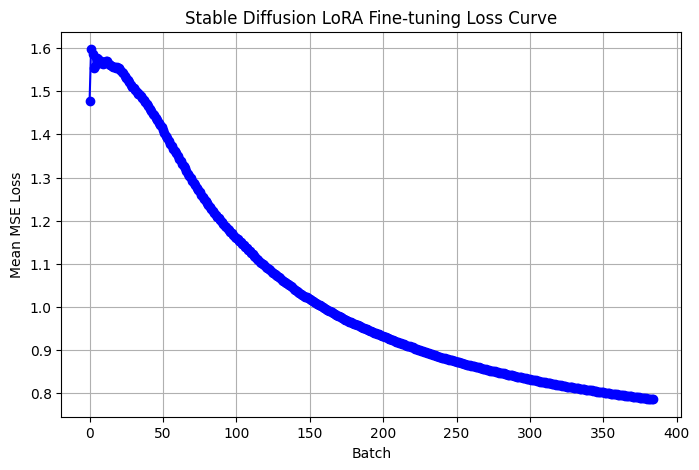

In [396]:
# Visualize training loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o', color='blue')
plt.title("Stable Diffusion LoRA Fine-tuning Loss Curve")
plt.xlabel("Batch")
plt.ylabel("Mean MSE Loss")
plt.grid(True)
plt.show()

In [397]:
# Attach trained components back to pipeline
unet = unet.merge_and_unload()  # Converts back to standard UNet

# Re-attach to pipeline
pipe.unet = unet
pipe.vae = vae
pipe.text_encoder = text_encoder
pipe.tokenizer = tokenizer


# Save the full fine-tuned pipeline
pipe.save_pretrained(out_dir)
pipe.tokenizer.save_pretrained(out_dir)

print(f"Pipeline saved successfully at {out_dir}")

Pipeline saved successfully at models/stable_diffusion_training


  0%|          | 0/30 [00:00<?, ?it/s]

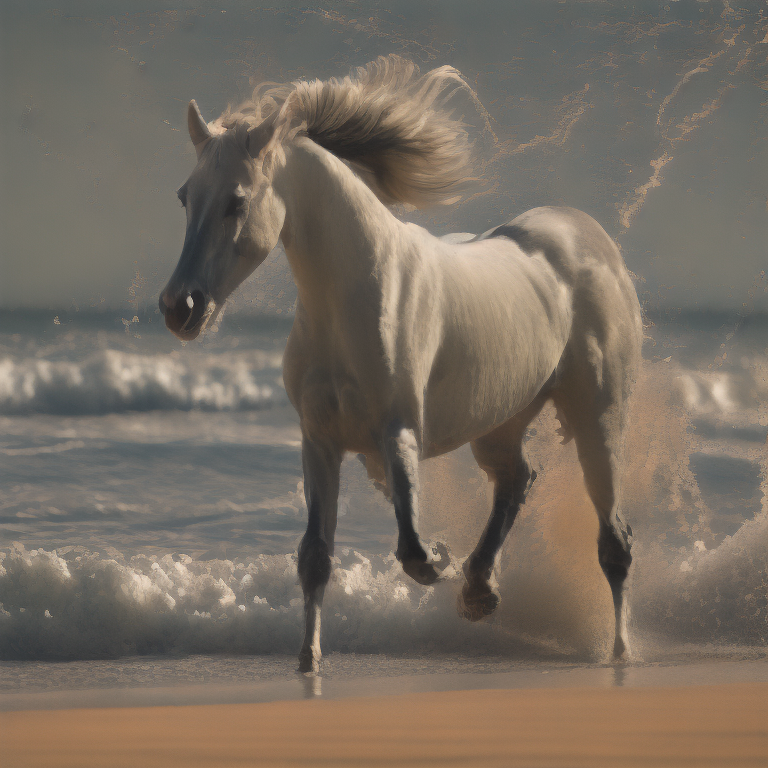

In [402]:
# Generating an initial image from a promt
init_prompt = "horse on a beach with waves that reaching its feet and the water splashes after striking its feet"
generator = torch.Generator(device=device).manual_seed(40)
init_image = pipe(init_prompt, negative_promt="blurry, satureated, deformed", guidance_scale=9, num_inference_steps=30, generator=generator).images[0]
init_image

In [403]:
# Creating s stable diffusion Image to Image pipeline.
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(base_model, torch_dtype=torch.float16).to(device)
pipe_img2img.unet.load_attn_procs(out_dir)
pipe_img2img.safety_checker = None
#pipe_img2img.enable_xformers_memory_efficient_attention()
pipe_img2img.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

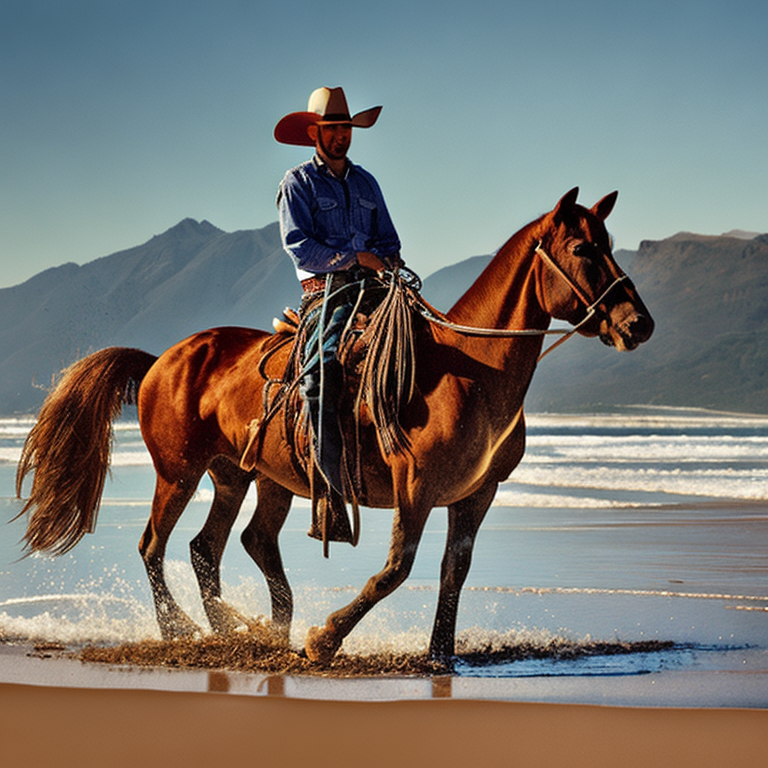

In [404]:
# Progressive image generation using the prompts
prompts = [
    "cowboy sitting straight on the horse on a beach with medium waves that reaches its feet and the water splashes after striking its feet",
    "cowboy sitting straight on the horse on a beach with medium waves that reaches its feet and the water splashes after striking its feet, mountains in the background"
]
generator = torch.Generator(device=device).manual_seed(42)

image = init_image
for i, prompt in enumerate(prompts):
    image = pipe_img2img(prompt=prompt, negative_promt="blurry, deformed, distorted,saturated", image=image, strength=0.9, guidance_scale=10.0 ,num_inference_steps=100, generator=generator).images[0]

image

In [405]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import upload_folder, upload_file
from huggingface_hub import HfApi

repo_id = "srmahapatra95/Diffusion-Model-Training-Beginner"
model_dir = "/workspace/models"
notebook_path = "/workspace/Diffusion_Models.ipynb"

api = HfApi()
api.create_repo(repo_id=repo_id, repo_type="model", private=False, exist_ok=True)


# Upload model folder
upload_folder(
    repo_id=repo_id,
    folder_path=model_dir,
    commit_message="Upload fine-tuned Stable Diffusion model with a custom dataset",
    path_in_repo="models"
)

# Upload the notebook
upload_file(
    path_or_fileobj=notebook_path,
    path_in_repo="Diffusion_Models.ipynb",
    repo_id=repo_id,
    commit_message="Add training notebook"
)

print(f"✅ Uploaded model + notebook successfully to https://huggingface.co/{repo_id}")


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            